<a href="https://colab.research.google.com/github/leocd91/geoscience-ML-tutorial/blob/main/06_Seismic_Event_Detection_(Seismology_Passive_Seismic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seismic Event Detection (Seismology / Passive Seismic)**

by : leocd91@gmail.com

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1t2AuUy4vj9F5DiZaDKpoCAfXvodq2hxz?usp=sharing">
        <img src="https://i.ibb.co/3723Hm9/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/leocd91/geoscience-ML-tutorial/tree/main">
        <img src="https://i.ibb.co/L5p10GH/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# **Introduction**


---
Welcome to the sixth episode of "***Geoscience ML Tutorial***" Series.

I made this tutorial as beginner-friendly as possible.
And some code are not *pythonic* for that reason too. Also this is only a straightforward tutorial, I expect you to learn more about approach in Machine learning workflow like feature engineering, data exploration, model evaluation, etc.

Oh yeah, for the deep learning part, We will use Pytorch.

any feedback just hmu.

---

**- Is there any Prereq.?**

> Programming, especially basic python OOP is a must. A basic idea how ML works. Also know how to run line of code in this colab (*hint: just click those 'play' button on the left*)

 **- Who are you giving some tutorials on the internet!?**

 

> I'm a Petrotechnical Data Management on a NOC in Indonesia. More than 5 years here and still going strong.

> I code my way to finish my undergraduate thesis (FDTD Elastic Wave in cuda) and get some side-gigs from there too (Inversion Method, Numerical Simulation, Etc.).

> I know some C, F95, and Matlab (Now I'm a Python Cult member tho ).

> My main interest is in computational geophysics and GP-GPU.

> I also *(lazily)* wrote some geocomputing stuff on [linkedin](https://www.linkedin.com/in/leo-c-0988727b/recent-activity/shares/) and my [blog](http://redigitize.blogspot.com/)

> I also ***love*** deep-fried banana.
 

 
 **TL;DR** I'm not a PhD, CEO, or Someone famous. I'm just glad that I can share something that I learn and learn more from this.

# **Getting ready**

Alright, before we start, 

If you are using colab, make sure it's in **GPU Runtime** *(Runtime -> Change Runtime)*

then let's install some useful package that we will use.

In [2]:
!pip install obspy # for reading segy data
!pip install torchsummary # for pytorch model architecture summary
!git clone https://github.com/leocd91/PyTorchWavelets

     |████████████████████████████████| 24.7 MB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp37-cp37m-linux_x86_64.whl size=21666161 sha256=0801f82f0dae7d37d837bb3f9f5956e521bad810f193f60b4836d09287aa389d
  Stored in directory: /root/.cache/pip/wheels/28/7e/ea/0a37d5f5001d096cf97d6527b60300badd2d0074449e89c736
Successfully built obspy
Cloning into 'PyTorchWavelets'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 107 (delta 1), reused 3 (delta 0), pack-reused 102
Receiving objects: 100% (107/107), 1.07 MiB | 1.43 MiB/s, done.
Resolving deltas: 100% (50/50), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [7]:
%cd PyTorchWavelets
!pip install .
%cd ..

/content/PyTorchWavelets
Processing /content/PyTorchWavelets
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for wavelets-pytorch: filename=wavelets_pytorch-0.1-py3-none-any.whl size=9973 sha256=5f2af77e305a2e15537143fb572b187bdb175084f743852fe62a9cdcd32ce54f
  Stored in directory: /tmp/pip-ephem-wheel-cache-eku7a1zn/wheels/6a/12/4d/b27d0b36fe909d7d736236bfb4c3ab5e89cd3b349078337988
Successfully built wavelets-pytorch
/content


**WARNING!**

If you are using google colab, make sure to **restart runtime** after installing obspy. Because of this [obspy](https://github.com/obspy/obspy/issues/2547#issuecomment-583123449) behaviour.

Then let's first import some package to use in these tutorials

In [1]:
import os
import numpy as np              # well, it's numpy.. powerful array and numerical computation tool (python's matlab)
import pandas as pd
import h5py                     #for reading the training data
import matplotlib.pyplot as plt # well, it's matplotlib.. for data visualization.. plotting
import obspy
import obspy.core as oc
from obspy import read_inventory
import time
import datetime
import torch                    # pytorch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  #for making a pytorch dataset-dataloader from training data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from wavelets_pytorch.transform import WaveletTransformTorch
from wavelets_pytorch.wavelets import Morlet, Ricker
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix #for score metric calculation
from sklearn.model_selection import train_test_split
from torchsummary import summary
import seaborn as sn
from tqdm import tqdm

For our Earthquake Seismic Event Detection, we will use [
The Italian seismic dataset for machine learning
](http://www.pi.ingv.it/instance/)

<img src="https://i0.wp.com/www.pi.ingv.it/wp-content/uploads/2021/04/banner.png?w=1996"  height="100px" style="padding-bottom:5px;"  />

*Citation : INSTANCE The Italian Seismic Dataset For Machine Learning, Alberto Michelini, Spina Cianetti, Sonja Gaviano, Carlo Giunchi, Dario Jozinović & Valentino Lauciani, Seismic Waveforms And Associated Metadata published 2021 in Istituto Nazionale di Geofisica e Vulcanologia (INGV) https://doi.org/10.13127/instance*

Okay, let's download it. For the sake of simplicity and running time, let's use the sample dataset, which I think it's quite enough.

In [9]:
!wget "http://repo.pi.ingv.it/instance/Instance_sample_dataset_v2.tar.bz2"

--2022-02-04 04:41:17--  http://repo.pi.ingv.it/instance/Instance_sample_dataset_v2.tar.bz2
Resolving repo.pi.ingv.it (repo.pi.ingv.it)... 193.204.89.18
Connecting to repo.pi.ingv.it (repo.pi.ingv.it)|193.204.89.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1776823636 (1.7G) [application/x-bzip2]
Saving to: ‘Instance_sample_dataset_v2.tar.bz2’

Instance_sample_dat 100%[===================>]   1.65G  10.8MB/s    in 2m 41s  

2022-02-04 04:43:59 (10.5 MB/s) - ‘Instance_sample_dataset_v2.tar.bz2’ saved [1776823636/1776823636]



Then extract the data

In [10]:
!tar -xjvf "/content/Instance_sample_dataset_v2.tar.bz2" -C "/content/"

data/
data/Instance_events_gm_10k.hdf5
data/Instance_events_counts_10k.hdf5
data/Instance_noise_1k.hdf5
metadata/
metadata/metadata_Instance_events_10k.csv
metadata/metadata_Instance_noise_1k.csv


Now let's load it then check the data sample of earthquake event and noise :

In [2]:
# directory PATH
METADIR = './metadata'
HDFDIR = './data'

# file NAMES
# metadata event and noise catalog 
events_metaname=os.path.join(METADIR,'metadata_Instance_events_10k.csv')
noise_metaname=os.path.join(METADIR,'metadata_Instance_noise_1k.csv')
# the waveform in HDF5
events_hdfname=os.path.join(HDFDIR,'Instance_events_counts_10k.hdf5')
noise_hdfname=os.path.join(HDFDIR,'Instance_noise_1k.hdf5')

Load the metadata / catalog file first :

In [3]:
events_metadata = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False)

In [13]:
events_metadata.head(5)

,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_origin_uncertainty_s,source_latitude_uncertainty_deg,source_longitude_uncertainty_deg,source_depth_uncertainty_km,source_stderror_s,source_gap_deg,source_horizontal_uncertainty_km,source_magnitude,source_magnitude_type,source_mt_eval_mode,source_mt_status,source_mt_scalar_moment_Nm,source_mechanism_strike_dip_rake,source_mechanism_moment_tensor,path_travel_time_P_s,path_travel_time_S_s,path_residual_P_s,path_residual_S_s,path_ep_distance_km,path_hyp_distance_km,path_azimuth_deg,path_backazimuth_deg,path_weight_phase_location_P,path_weight_phase_location_S,trace_start_time,trace_dt_s,...,trace_N_snr_db,trace_Z_snr_db,trace_E_pga_cmps2,trace_E_pgv_cmps,trace_E_pga_perc,trace_E_pga_time,trace_E_pgv_time,trace_E_sa03_cmps2,trace_E_sa10_cmps2,trace_E_sa30_cmps2,trace_N_pga_cmps2,trace_N_pgv_cmps,trace_N_pga_perc,trace_N_pga_time,trace_N_pgv_time,trace_N_sa03_cmps2,trace_N_sa10_cmps2,trace_N_sa30_cmps2,trace_Z_pga_cmps2,trace_Z_pgv_cmps,trace_Z_pga_perc,trace_Z_pga_time,trace_Z_pgv_time,trace_Z_sa03_cmps2,trace_Z_sa10_cmps2,trace_Z_sa30_cmps2,trace_pga_cmps2,trace_pgv_cmps,trace_pga_perc,trace_sa03_cmps2,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,source_type
0,11030611,IV,OFFI,,HH,42.93500,13.68570,320.0,580.000000,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,9.22,,0.80,,44.001059,44.952566,87.400156,267.766910,38.0,,2016-12-04T15:34:43.92Z,0.01,...,21.553444101,13.7796243522,0.0391153614229,0.0012714486816,0.00398865682194,2016-12-04T15:35:12.420000Z,2016-12-04T15:35:12.470000Z,0.005560,0.000851,0.000060,0.0458200226859,0.00175449714608,0.00467234200118,2016-12-04T15:35:10.050000Z,2016-12-04T15:35:09.730000Z,0.005031,0.001040,0.000094,0.0161519470333,0.00065557580312,0.0016470402261,2016-12-04T15:35:10.850000Z,2016-12-04T15:35:10.790000Z,0.003583,0.000285,0.000083,0.0458200226859,0.00175449714608,0.00467234200118,0.00555950331545,0.001040,9.36700287089e-05,11030611.IV.OFFI..HH,1,2,1.0,1.0,1.0,mps,earthquake
1,11030611,IV,PIEI,,HH,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,14.85,,0.16,,84.721992,85.220045,324.262281,143.842983,42.0,,2016-12-04T15:34:48.14Z,0.01,...,9.51894582876,6.88454263894,0.0059708542567,0.00015456677082,0.000608857689089,2016-12-04T15:35:25.040100Z,2016-12-04T15:35:25.020100Z,0.000518,0.000053,0.000010,0.0025851661777,7.55400984124e-05,0.000263613586464,2016-12-04T15:35:23.960300Z,2016-12-04T15:35:24.440300Z,0.000334,0.000043,0.000015,0.00286586440089,7.44394204078e-05,0.000292236839378,2016-12-04T15:35:23.580100Z,2016-12-04T15:35:24.970100Z,0.000301,0.000048,0.000012,0.0059708542567,0.00015456677082,0.000608857689089,0.000518144535689,0.000053,1.49377156134e-05,11030611.IV.PIEI..HH,0,2,1.0,1.0,1.0,mps,earthquake
2,11030611,IV,PIEI,,HN,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,14.85,,0.16,,84.721992,85.220045,324.262281,143.842983,42.0,,2016-12-04T15:34:48.00Z,0.01,...,4.51903842886,4.30368521166,0.00490707117503,0.000478704676892,0.000500382003541,2016-12-04T15:35:25.060200Z,2016-12-04T15:35:43.600200Z,0.000556,0.000132,0.000078,0.00324716667938,0.000352667366328,0.000331118850921,2016-12-04T15:35:39.620200Z,2016-12-04T15:35:19.140200Z,0.000420,0.000239,0.000067,0.00347174396077,0.000327466115716,0.000354019360411,2016-12-04T15:35:23.590300Z,2016-12-04T15:35:03.030300Z,0.000352,0.000171,0.000083,0.00490707117503,0.0

Load the waveform recoring :

In [4]:
events_h5File = h5py.File(events_hdfname, 'r') 

In [5]:
row = events_metadata.iloc[0,:] #check the waveform of the first event in catalog
stats = oc.Stats()
stats.npts = 12000
stats.sampling_rate = 100.

sta = row['station_code']
wav_name = row['trace_name']
ev_id = row['source_id']
net = row['station_network_code']
parr = row['trace_P_arrival_sample']
waveform = events_h5File['data'][row['trace_name']]

stats.delta = row['trace_dt_s']
stats.starttime = pd.to_datetime(row['trace_start_time'])
stats.network = net
stats.station = sta

st = oc.Stream()
for i in range (0,3):
    tr = oc.Trace()
    tr.data = waveform[i]
    tr.stats = stats
    if i == 0:
        tr.stats.channel = row['station_channels']+'E'
    if i == 1:
        tr.stats.channel = row['station_channels']+'N'
    if i == 2:
        tr.stats.channel = row['station_channels']+'Z'
    tr +=tr
    st.append(tr)        

latest_start = np.max([x.stats.starttime for x in st])
earliest_stop = np.min([x.stats.endtime for x in st])
st.trim(latest_start, earliest_stop)
st.detrend(type='linear') #detrend the signal

#change it to numpy
wavdata = np.vstack([st[0].data,st[1].data,st[2].data]).astype(float)

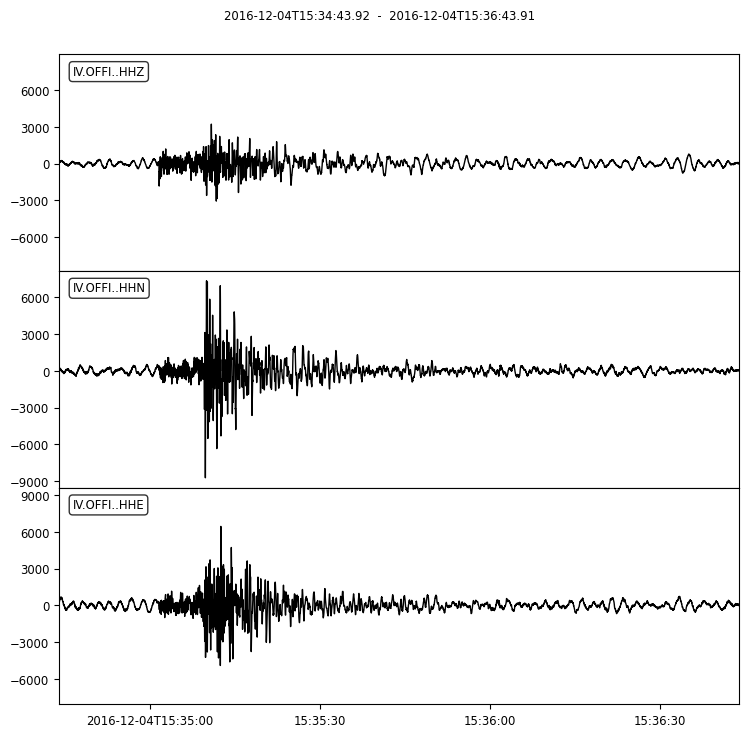

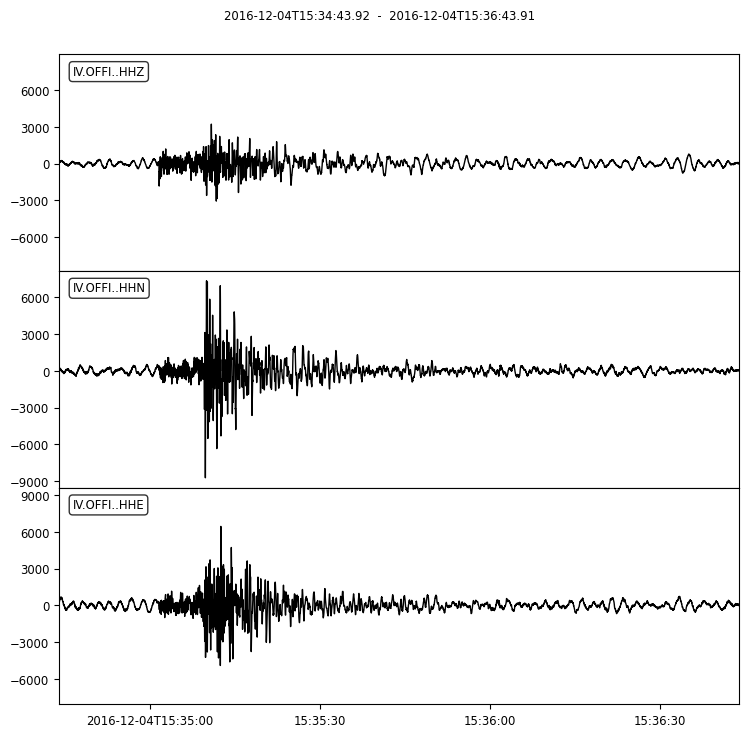

In [6]:
st.plot()

Now let's check the noise:

In [7]:
noise_metaname=os.path.join(METADIR,'metadata_Instance_noise_1k.csv')
noise_hdfname=os.path.join(HDFDIR,'Instance_noise_1k.hdf5')
noise_metadata = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)
noise_h5File = h5py.File(noise_hdfname, 'r')

In [12]:
row = noise_metadata.iloc[111,:]
stats = oc.Stats()
stats.npts = 12000
stats.sampling_rate = 100.

sta = row['station_code']
wav_name = row['trace_name']
ev_id = row['source_id']
net = row['station_network_code']
#parr = row['trace_P_arrival_sample']
waveform = noise_h5File['data'][row['trace_name']]

stats.delta = row['trace_dt_s']
stats.starttime = pd.to_datetime(row['trace_start_time'])
stats.network = net
stats.station = sta

st = oc.Stream()
for i in range (0,3):
    tr = oc.Trace()
    tr.data = waveform[i]
    tr.stats = stats
    if i == 0:
        tr.stats.channel = row['station_channels']+'E'
    if i == 1:
        tr.stats.channel = row['station_channels']+'N'
    if i == 2:
        tr.stats.channel = row['station_channels']+'Z'
    tr +=tr
    st.append(tr)        

latest_start = np.max([x.stats.starttime for x in st])
earliest_stop = np.min([x.stats.endtime for x in st])
st.trim(latest_start, earliest_stop)
st.detrend(type='linear')

3 Trace(s) in Stream:
IV.PARC..HHE | 2017-08-20T08:53:49.880000Z - 2017-08-20T08:55:49.870000Z | 100.0 Hz, 12000 samples
IV.PARC..HHN | 2017-08-20T08:53:49.880000Z - 2017-08-20T08:55:49.870000Z | 100.0 Hz, 12000 samples
IV.PARC..HHZ | 2017-08-20T08:53:49.880000Z - 2017-08-20T08:55:49.870000Z | 100.0 Hz, 12000 samples

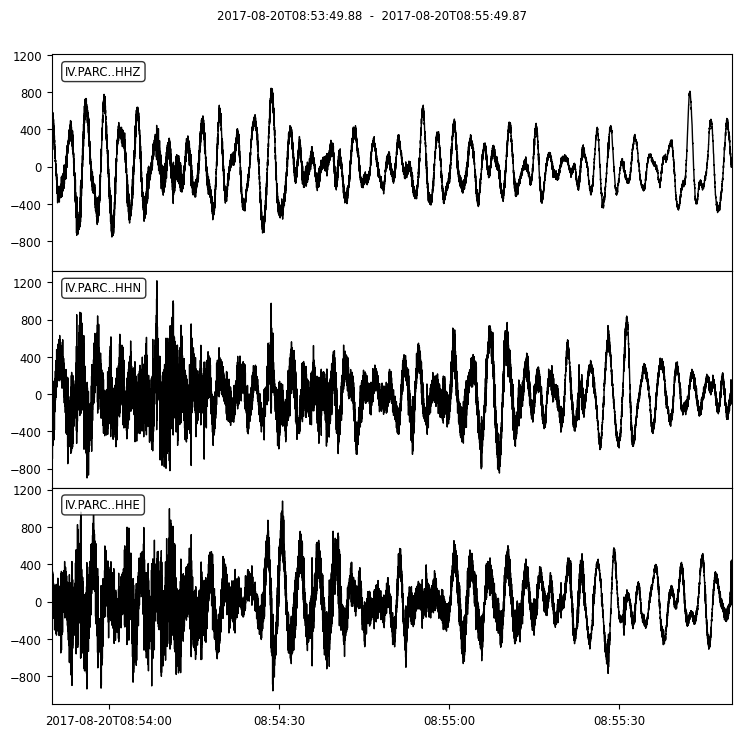

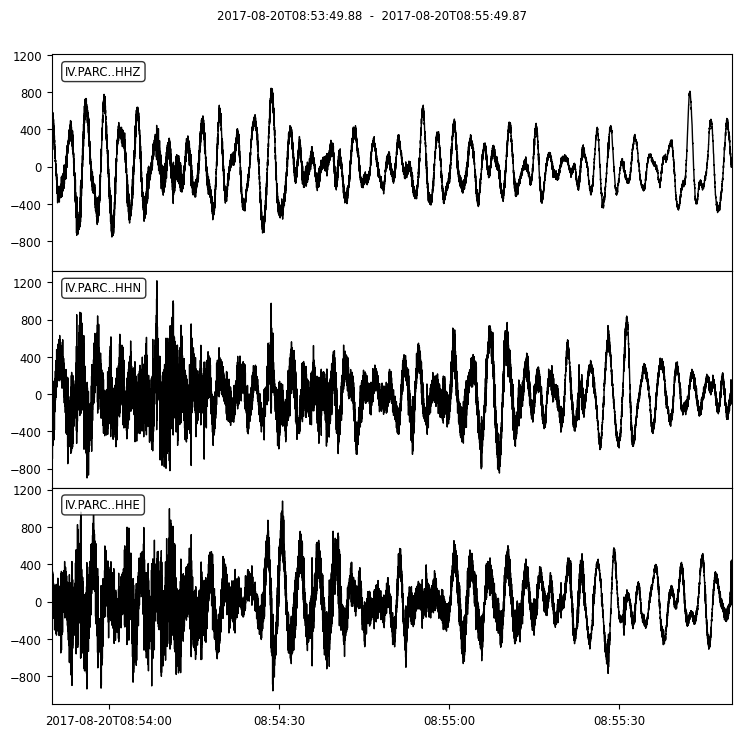

In [13]:
st.plot()

In [14]:
#change it to numpy
wavdata2 = np.vstack([st[0].data,st[1].data,st[2].data]).astype(float)

Before we feed it to our ML model, I remember the best solution to an footstep audio classification challenge is by using its spectral domain of the data.

I can't remember where it from, Google failed me (or maybe I'm the one who put the wrong keywords),
So please let me know the site so I can put some credit here.

Let's check it ourselves to see if its applicable on seismic data.


In [15]:
wa_torch = WaveletTransformTorch(0.01, 0.1, wavelet=Morlet(w0=6), unbias=False, cuda=True)

In [24]:
power_torch = wa_torch.power(wavdata)

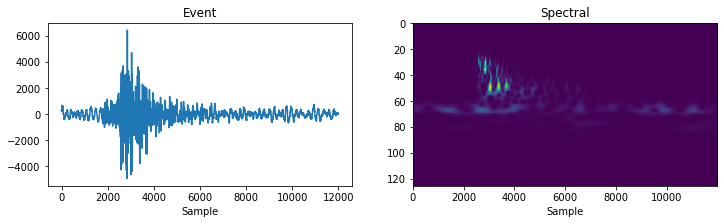

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax = ax.flatten()
ax[0].plot(wavdata[0])
ax[0].set_title(r'Event')
ax[0].set_xlabel('Sample')

ax[1].imshow(power_torch[0], interpolation='none', aspect='auto')
ax[1].set_title(r'Spectral')
ax[1].set_xlabel('Sample')
#plt.tight_layout()
plt.show()

In [26]:
power_torch = wa_torch.power(wavdata2)

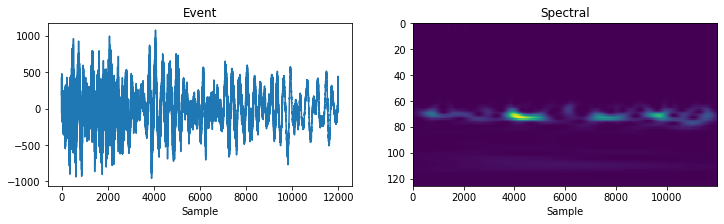

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax = ax.flatten()
ax[0].plot(wavdata2[0])
ax[0].set_title(r'Event')
ax[0].set_xlabel('Sample')

ax[1].imshow(power_torch[0], interpolation='none', aspect='auto')
ax[1].set_title(r'Spectral')
ax[1].set_xlabel('Sample')
plt.show()

Aha! Look at the differences. Let's feed that instead of raw recordings later.

# **Making the Dataset, Set Up the ML Parameters**

Now to set everything up, first let's merge the catalog / metadata and add a label flag to differentiate it between earthquake and noise.

In [28]:
events_metadata['label'] = 1
noise_metadata['label'] = 0
metadata= events_metadata.append(noise_metadata, ignore_index=True)
metadata.head(5)

,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_origin_uncertainty_s,source_latitude_uncertainty_deg,source_longitude_uncertainty_deg,source_depth_uncertainty_km,source_stderror_s,source_gap_deg,source_horizontal_uncertainty_km,source_magnitude,source_magnitude_type,source_mt_eval_mode,source_mt_status,source_mt_scalar_moment_Nm,source_mechanism_strike_dip_rake,source_mechanism_moment_tensor,path_travel_time_P_s,path_travel_time_S_s,path_residual_P_s,path_residual_S_s,path_ep_distance_km,path_hyp_distance_km,path_azimuth_deg,path_backazimuth_deg,path_weight_phase_location_P,path_weight_phase_location_S,trace_start_time,trace_dt_s,...,trace_Z_snr_db,trace_E_pga_cmps2,trace_E_pgv_cmps,trace_E_pga_perc,trace_E_pga_time,trace_E_pgv_time,trace_E_sa03_cmps2,trace_E_sa10_cmps2,trace_E_sa30_cmps2,trace_N_pga_cmps2,trace_N_pgv_cmps,trace_N_pga_perc,trace_N_pga_time,trace_N_pgv_time,trace_N_sa03_cmps2,trace_N_sa10_cmps2,trace_N_sa30_cmps2,trace_Z_pga_cmps2,trace_Z_pgv_cmps,trace_Z_pga_perc,trace_Z_pga_time,trace_Z_pgv_time,trace_Z_sa03_cmps2,trace_Z_sa10_cmps2,trace_Z_sa30_cmps2,trace_pga_cmps2,trace_pgv_cmps,trace_pga_perc,trace_sa03_cmps2,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,source_type,label
0,11030611,IV,OFFI,,HH,42.93500,13.68570,320.0,580.000000,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,9.22,,0.80,,44.001059,44.952566,87.400156,267.766910,38.0,,2016-12-04T15:34:43.92Z,0.01,...,13.7796243522,0.0391153614229,0.0012714486816,0.00398865682194,2016-12-04T15:35:12.420000Z,2016-12-04T15:35:12.470000Z,0.005560,0.000851,0.000060,0.0458200226859,0.00175449714608,0.00467234200118,2016-12-04T15:35:10.050000Z,2016-12-04T15:35:09.730000Z,0.005031,0.001040,0.000094,0.0161519470333,0.00065557580312,0.0016470402261,2016-12-04T15:35:10.850000Z,2016-12-04T15:35:10.790000Z,0.003583,0.000285,0.000083,0.0458200226859,0.00175449714608,0.00467234200118,0.00555950331545,0.001040,9.36700287089e-05,11030611.IV.OFFI..HH,1,2,1.0,1.0,1.0,mps,earthquake,1
1,11030611,IV,PIEI,,HH,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,14.85,,0.16,,84.721992,85.220045,324.262281,143.842983,42.0,,2016-12-04T15:34:48.14Z,0.01,...,6.88454263894,0.0059708542567,0.00015456677082,0.000608857689089,2016-12-04T15:35:25.040100Z,2016-12-04T15:35:25.020100Z,0.000518,0.000053,0.000010,0.0025851661777,7.55400984124e-05,0.000263613586464,2016-12-04T15:35:23.960300Z,2016-12-04T15:35:24.440300Z,0.000334,0.000043,0.000015,0.00286586440089,7.44394204078e-05,0.000292236839378,2016-12-04T15:35:23.580100Z,2016-12-04T15:35:24.970100Z,0.000301,0.000048,0.000012,0.0059708542567,0.00015456677082,0.000608857689089,0.000518144535689,0.000053,1.49377156134e-05,11030611.IV.PIEI..HH,0,2,1.0,1.0,1.0,mps,earthquake,1
2,11030611,IV,PIEI,,HN,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,2016-12-04T15:34:52.05Z,42.9183,13.1472,9.2,0.03,0.0018,0.0037,0.2,0.26,34.0,0.26,2.5,ML,,,,,,14.85,,0.16,,84.721992,85.220045,324.262281,143.842983,42.0,,2016-12-04T15:34:48.00Z,0.01,...,4.30368521166,0.00490707117503,0.000478704676892,0.000500382003541,2016-12-04T15:35:25.060200Z,2016-12-04T15:35:43.600200Z,0.000556,0.000132,0.000078,0.00324716667938,0.000352667366328,0.000331118850921,2016-12-04T15:35:39.620200Z,2016-12-04T15:35:19.140200Z,0.000420,0.000239,0.000067,0.00347174396077,0.000327466115716,0.000354019360411,2016-12-04T15:35:23.590300Z,2016-12-04T15:35:03.030300Z,0.000352,0.000171,0.000083,0.00490707117503,0.000478704676892,0.000500382003541,0.00055594341

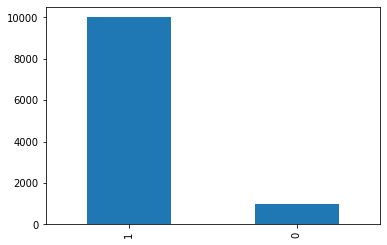

In [33]:
metadata['label'].value_counts().plot(kind='bar')
plt.show()

Split the dataset into :    


1.   Training Dataset
2.   Testing Dataset
3.   Hold-out Validation Dataset



In [31]:
data_tr, data_val = train_test_split(metadata, test_size=0.2, random_state=3355, stratify=metadata['label'])
data_train, data_test = train_test_split(data_tr, test_size=0.2, random_state=3355, stratify=data_tr['label'])

Make the dataset class :

In [36]:
class seisdataset(Dataset):
    def __init__(self, data, events_h5File, noise_h5File):
        super().__init__()
        self.data = data


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):

        label = self.data['label'].iloc[index]
        if label == 1:
            row = self.data.iloc[index,:]
            waveform = events_h5File['data'][row['trace_name']]            
        else :
            row = self.data.iloc[index,:]
            waveform = noise_h5File['data'][row['trace_name']]
        stats = oc.Stats()
        stats.npts = 12000
        stats.sampling_rate = 100.

        sta = row['station_code']
        wav_name = row['trace_name']
        ev_id = row['source_id']
        net = row['station_network_code']
        stats.delta = row['trace_dt_s']
        stats.starttime = pd.to_datetime(row['trace_start_time'])
        stats.network = net
        stats.station = sta

        st = oc.Stream()
        for i in range (0,3):
            tr = oc.Trace()
            tr.data = waveform[i]
            tr.stats = stats
            if i == 0:
                tr.stats.channel = row['station_channels']+'E'
            if i == 1:
                tr.stats.channel = row['station_channels']+'N'
            if i == 2:
                tr.stats.channel = row['station_channels']+'Z'
            tr +=tr
            st.append(tr)  

            
            
        latest_start = np.max([x.stats.starttime for x in st])
        earliest_stop = np.min([x.stats.endtime for x in st])
        st.trim(latest_start, earliest_stop)
        #st.detrend(type='linear')
        st.detrend(type='spline', order=3, dspline=500)
        st.resample(10.0)
        wavdata = np.vstack([st[0].data,st[1].data,st[2].data]).astype(float)
        
        #wavelet transform param
        fps = 10
        dt  = 1.0/fps
        dj  = 0.1
        unbias = False
        wavelet = Morlet(w0=6)
        wavdata = wa_torch.power(wavdata)    
        result = wavdata.copy()
        #rescale the spectral
        result[0] = (wavdata[0] - wavdata[0].min()) / (wavdata[0].max() - wavdata[0].min())
        result[1] = (wavdata[1] - wavdata[1].min()) / (wavdata[1].max() - wavdata[1].min())
        result[2] = (wavdata[2] - wavdata[2].min()) / (wavdata[2].max() - wavdata[2].min())        
        return transforms.ToTensor()(result).float().permute(1, 2, 0), label

Assigning some training parameters :

In [43]:
batch_size = 16
num_epochs = 50
num_classes = 2
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Calling the model architecture from pytorch model zoo, we will user resnet18.

Let's see if it's enough. 

In [39]:
model = torchvision.models.resnet18(pretrained=False)
model = model.cuda() if device else net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.fc = model.fc.cuda()

In [44]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate) # the optimizer, we use ADAM

In [40]:
summary(model, (3, 93, 1200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 47, 600]           9,408
       BatchNorm2d-2          [-1, 64, 47, 600]             128
              ReLU-3          [-1, 64, 47, 600]               0
         MaxPool2d-4          [-1, 64, 24, 300]               0
            Conv2d-5          [-1, 64, 24, 300]          36,864
       BatchNorm2d-6          [-1, 64, 24, 300]             128
              ReLU-7          [-1, 64, 24, 300]               0
            Conv2d-8          [-1, 64, 24, 300]          36,864
       BatchNorm2d-9          [-1, 64, 24, 300]             128
             ReLU-10          [-1, 64, 24, 300]               0
       BasicBlock-11          [-1, 64, 24, 300]               0
           Conv2d-12          [-1, 64, 24, 300]          36,864
      BatchNorm2d-13          [-1, 64, 24, 300]             128
             ReLU-14          [-1, 64, 

As you can see from the Torchsummary, go tweak your batch_size and input size see if your vram is enough. (no worries for colab user)

Now put it into the dataloader.

In [42]:
train_data = seisdataset(data_train, events_h5File, noise_h5File)
test_data = seisdataset(data_test, events_h5File, noise_h5File)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, drop_last=True)

# **Training**

It's going to take some time to train this, if you are running it using non-pro google colab, probably you'll be kicked out.

You can skip this step and use the pretrained weight below on validation part.

In [ ]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
train_acc = []
test_acc = []

final_pred=[]
final_target=[]
F1_old = 0.0

for epoch in range(1, num_epochs + 1):
    
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0  
    
    # train the model
    model.train()
    for data, target in tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()

        output = model(data.float())

        loss = criterion(output.squeeze(), target.long())
        acc = accuracy_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1))
        f1s = f1_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1) ,average='weighted')

        loss.backward()

        optimizer.step()
        #lr_sched.step()

        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc
        
    # test the model
    model.eval()
    for data, target in tqdm(test_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data.float())

        loss = criterion(output.squeeze(), target.long())
        acc = accuracy_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1))
        f1s = f1_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1) ,average='weighted')

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc
        
        if epoch==num_epochs:
            final_target.append(target.cpu().numpy())
            final_pred.append(np.argmax(output.detach().cpu().numpy(), axis=1))
        
    # calculate losses, metric, for logging
    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      
    
    #save best model
    if F1_old < F1_test:
      F1_old = F1_test
      torch.save(model.state_dict(), 'bestmodel.ckpt')

    # print logging
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test))
print('Best F1:', F1_old)

Let's see the training log :

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15,3))

ax1.plot(train_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_title('losses')

ax2.plot(train_acc, label='Train Accuracy')
ax2.plot(test_acc, label='Test Accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('% acc')
ax2.set_title('Accuracy')

ax3.plot(train_F1, label='Train F1')
ax3.plot(test_F1, label='Test F1')
ax3.set_title('F1-Score')

plt.legend(['Train','Test'])
plt.show()

# **Validation**

downloading pretrained model (**if you skip the training part**)

In [49]:
!gdown --id 1j1UO05JUBRDEBlVxaz6AHUQ_M6Bx9DW0

Downloading...
From: https://drive.google.com/uc?id=1j1UO05JUBRDEBlVxaz6AHUQ_M6Bx9DW0
To: /content/bestmodel.ckpt
100% 44.8M/44.8M [00:00<00:00, 76.7MB/s]


load the best model trained (or the pretrained one) :

In [50]:
model.load_state_dict(torch.load('bestmodel.ckpt'))

<All keys matched successfully>

Let's test the hold out validation set!

In [51]:
val_data = seisdataset(data_val, events_h5File, noise_h5File)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle=False, drop_last=True)

In [52]:
model.eval()
F1_val = 0.0
acc_val = 0.0  
final_pred=[]
final_target=[]
for data, target in tqdm(val_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data.float())
    acc = accuracy_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1))
    f1s = f1_score(target.cpu().numpy(), np.argmax(output.squeeze().detach().cpu().numpy(), axis=1) ,average='weighted')
    F1_val += f1s
    acc_val += acc
    final_target.append(target.cpu().numpy().tolist())
    final_pred.append(np.argmax(output.detach().cpu().numpy(), axis=1).tolist())
F1_val = F1_val/len(val_loader.sampler)*batch_size
acc_val = acc_val/len(val_loader.sampler)*batch_size

100%|██████████| 137/137 [03:25<00:00,  1.50s/it]


In [53]:
print("F1 weighted:",F1_val,"; Accuracy:",acc_val)

F1 weighted: 0.957925222471 ; Accuracy: 0.958181818182


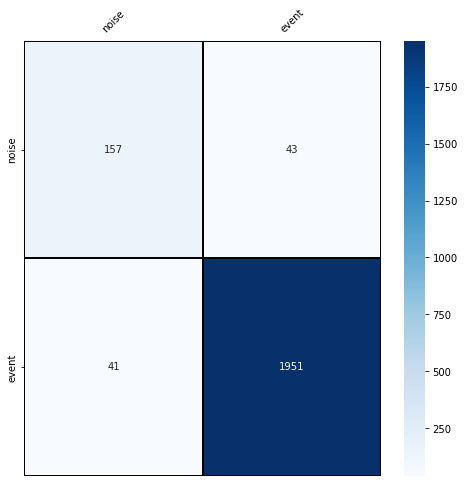

In [54]:
fig2 = plt.figure(figsize=(8,8))
confm = confusion_matrix(np.array(final_target).flatten(), np.array(final_pred).flatten())
ax = sn.heatmap(confm, xticklabels=['noise','event'], yticklabels=['noise','event'], cmap='Blues', annot=True, fmt='g', linewidths=1, linecolor='black') 
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation=45) 
plt.show()

# **Prediction**

Let's find some recent data from INGV to test [here](http://terremoti.ingv.it/en/events?starttime=2022-01-05+00%3A00%3A00&endtime=2022-02-04+23%3A59%3A59&last_nd=30&minmag=2&maxmag=10&mindepth=-10&maxdepth=1000&minlat=35&maxlat=49&minlon=5&maxlon=20&minversion=100&limit=30&orderby=ot-desc&lat=0&lon=0&maxradiuskm=-1&wheretype=area&box_search=Italia&timezone=UTC)



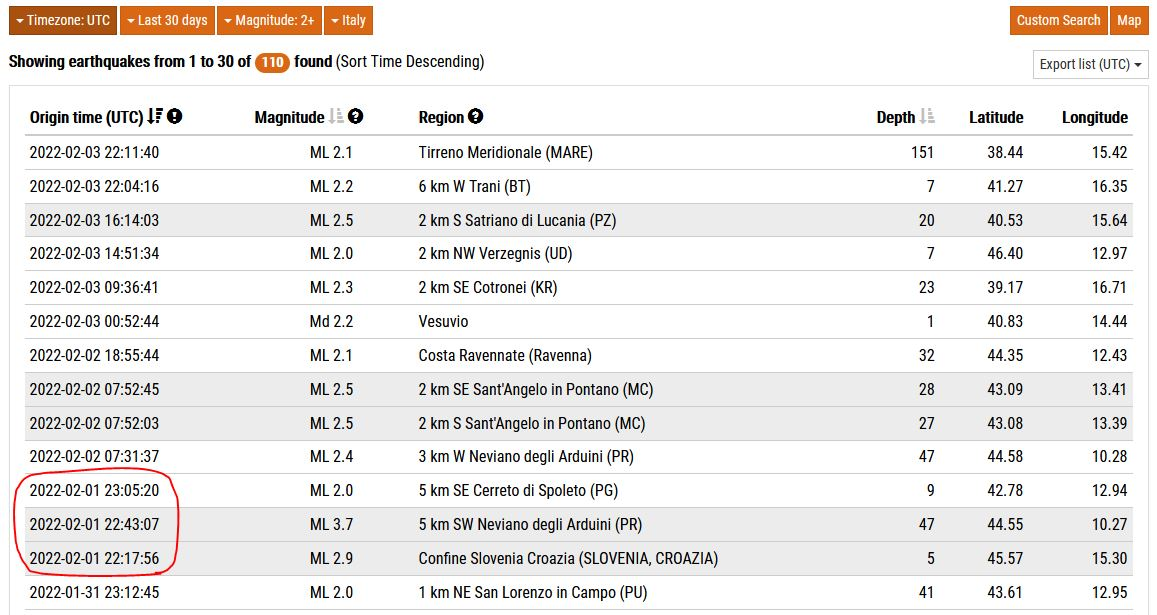

That one from February 1st seems big enough, Lets get the waveform recording for two hours from 22:00 PM until Midnight.

you can download it [here](http://eida.ingv.it/en/getdata#dataselecttc) or via command bellow :

In [72]:
 !wget -O 'IV_LNSS_01022022_2324.mseed' 'https://webservices.ingv.it/fdsnws/dataselect/1/query?starttime=2022-02-01T22:00:00&endtime=2022-02-01T23:59:00&network=IV&station=LNSS&channel=HH?'

--2022-02-04 08:39:09--  https://webservices.ingv.it/fdsnws/dataselect/1/query?starttime=2022-02-01T22:00:00&endtime=2022-02-01T23:59:00&network=IV&station=LNSS&channel=HH?
Resolving webservices.ingv.it (webservices.ingv.it)... 93.63.207.206
Connecting to webservices.ingv.it (webservices.ingv.it)|93.63.207.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.fdsn.mseed]
Saving to: ‘IV_LNSS_01022022_2324.mseed’

IV_LNSS_01022022_23     [       <=>          ]   3.15M   487KB/s    in 7.2s    

2022-02-04 08:39:19 (445 KB/s) - ‘IV_LNSS_01022022_2324.mseed’ saved [3302912]



In [73]:
st2 = obspy.read("./IV_LNSS_01022022_2324.mseed", format="mseed")
st2.detrend(type='spline', order=3, dspline=500)
st2.resample(10.0)
wav_len = np.min([st2[0].data.shape[0],st2[1].data.shape[0],st2[2].data.shape[0]])
wavdata = np.vstack([st2[0].data[:wav_len],st2[1].data[:wav_len],st2[2].data[:wav_len]]).astype(float)

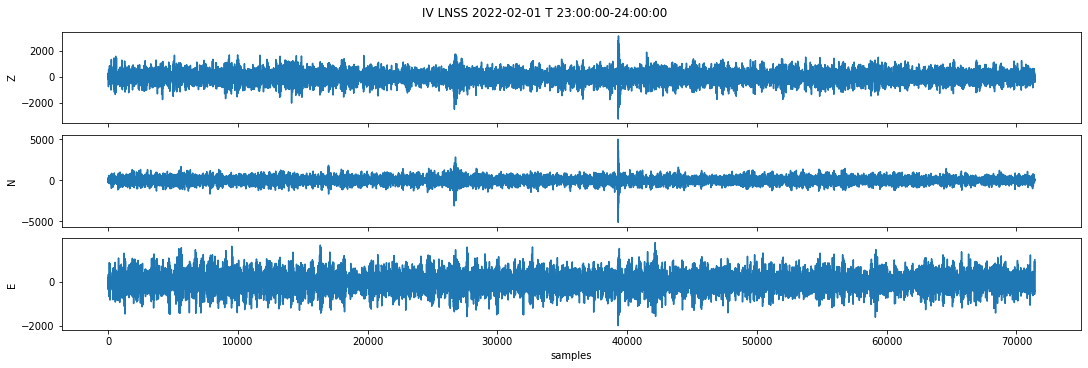

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True, figsize=(15,5), sharex=True)
fig.suptitle('IV LNSS 2022-02-01 T 23:00:00-24:00:00')
ax1.plot(wavdata[0], label='Z')
ax1.set_ylabel('Z')
ax2.plot(wavdata[1], label='N')
ax2.set_ylabel('N')
ax3.plot(wavdata[2], label='E')
ax3.set_ylabel('E')
ax3.set_xlabel('samples')

plt.show()

In [75]:
idx = np.arange(0,wav_len,1200)
event_pred = []
for i in range(0,len(idx)-1):
    wavinput = wavdata[:,idx[i]:idx[i+1]].copy()
    #transform
    fps = 10
    dt  = 1.0/fps
    dj  = 0.1
    unbias = False
    wavelet = Morlet(w0=6)
    wavinput = wa_torch.power(wavinput)   
    result = wavinput.copy()
    result[0] = (wavinput[0] - wavinput[0].min()) / (wavinput[0].max() - wavinput[0].min())
    result[1] = (wavinput[1] - wavinput[1].min()) / (wavinput[1].max() - wavinput[1].min())
    result[2] = (wavinput[2] - wavinput[2].min()) / (wavinput[2].max() - wavinput[2].min()) 
    output = model(torch.from_numpy(result).unsqueeze(0).float().to(device))
    label_pred = np.argmax(output.squeeze().detach().cpu().numpy(), axis=0)
    event_pred.append(label_pred)

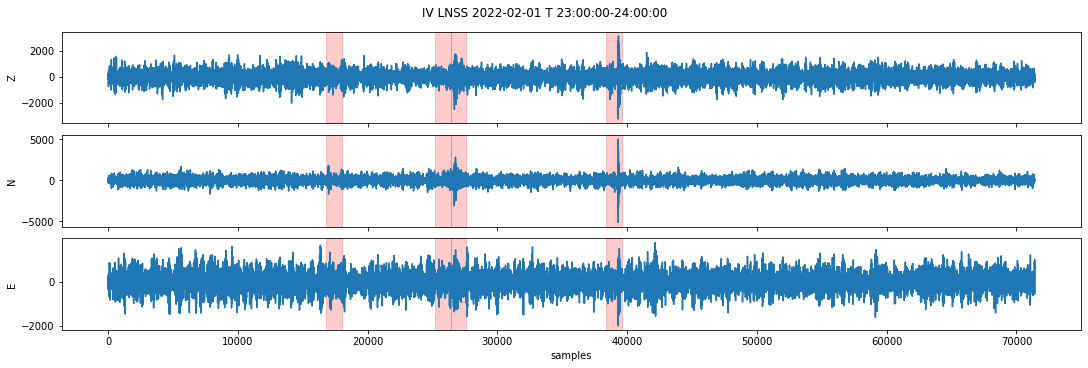

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True, figsize=(15,5), sharex=True)
fig.suptitle('IV LNSS 2022-02-01 T 23:00:00-24:00:00')
ax1.plot(wavdata[0], label='Z')
ax1.set_ylabel('Z')

ax2.plot(wavdata[1], label='N')
ax2.set_ylabel('N')
ax3.plot(wavdata[2], label='E')
ax3.set_ylabel('E')
ax3.set_xlabel('samples')

for i in range(len(event_pred)):
    if event_pred[i]==1:
        ax1.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)
        ax2.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)
        ax3.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)

plt.show()

Well, that's quite good isn't it? considering we are still using the small dataset version.

Let's try it from another station :

In [55]:
 !wget -O 'IV_NRCA_01022022_2324.mseed' 'https://webservices.ingv.it/fdsnws/dataselect/1/query?starttime=2022-02-01T22:00:00&endtime=2022-02-01T23:59:00&network=IV&station=NRCA&channel=HH?'

--2022-02-04 08:29:11--  https://webservices.ingv.it/fdsnws/dataselect/1/query?starttime=2022-02-01T22:00:00&endtime=2022-02-01T23:59:00&network=IV&station=NRCA&channel=HH?
Resolving webservices.ingv.it (webservices.ingv.it)... 93.63.207.206
Connecting to webservices.ingv.it (webservices.ingv.it)|93.63.207.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.fdsn.mseed]
Saving to: ‘IV_NRCA_01022022_2324.mseed’

IV_NRCA_01022022_23     [        <=>         ]   2.59M  1.13MB/s    in 2.3s    

2022-02-04 08:29:15 (1.13 MB/s) - ‘IV_NRCA_01022022_2324.mseed’ saved [2718208]



In [56]:
st2 = obspy.read("./IV_NRCA_01022022_2324.mseed", format="mseed")
st2.detrend(type='spline', order=3, dspline=500)
st2.resample(10.0)
wav_len = np.min([st2[0].data.shape[0],st2[1].data.shape[0],st2[2].data.shape[0]])
wavdata = np.vstack([st2[0].data[:wav_len],st2[1].data[:wav_len],st2[2].data[:wav_len]]).astype(float)

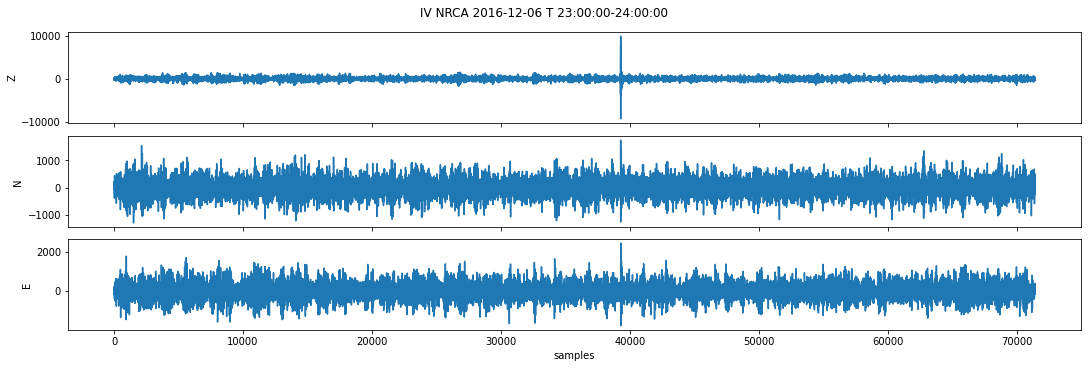

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True, figsize=(15,5), sharex=True)
fig.suptitle('IV NRCA 2022-02-01 T 23:00:00-24:00:00')
ax1.plot(wavdata[0], label='Z')
ax1.set_ylabel('Z')
ax2.plot(wavdata[1], label='N')
ax2.set_ylabel('N')
ax3.plot(wavdata[2], label='E')
ax3.set_ylabel('E')
ax3.set_xlabel('samples')

plt.show()

In [58]:
idx = np.arange(0,wav_len,1200)
event_pred = []
for i in range(0,len(idx)-1):
    wavinput = wavdata[:,idx[i]:idx[i+1]].copy()
    #transform
    fps = 10
    dt  = 1.0/fps
    dj  = 0.1
    unbias = False
    wavelet = Morlet(w0=6)
    wavinput = wa_torch.power(wavinput)   
    result = wavinput.copy()
    result[0] = (wavinput[0] - wavinput[0].min()) / (wavinput[0].max() - wavinput[0].min())
    result[1] = (wavinput[1] - wavinput[1].min()) / (wavinput[1].max() - wavinput[1].min())
    result[2] = (wavinput[2] - wavinput[2].min()) / (wavinput[2].max() - wavinput[2].min()) 
    output = model(torch.from_numpy(result).unsqueeze(0).float().to(device))
    label_pred = np.argmax(output.squeeze().detach().cpu().numpy(), axis=0)
    event_pred.append(label_pred)

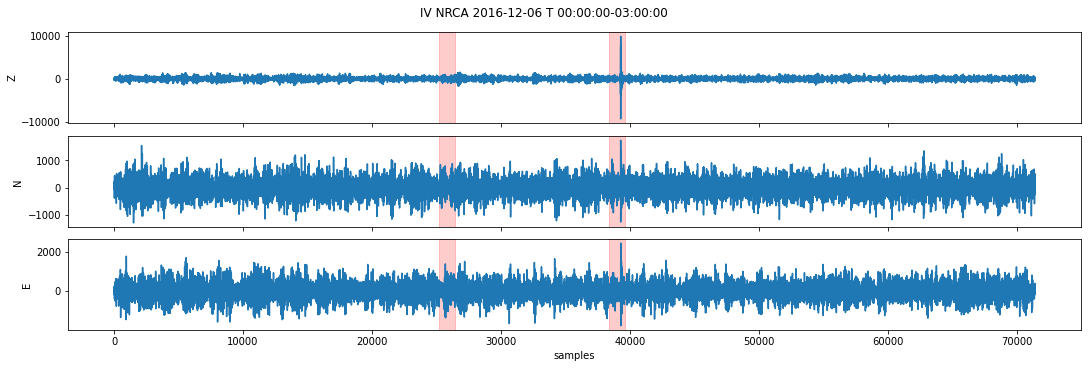

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True, figsize=(15,5), sharex=True)
fig.suptitle('IV NRCA 2022-02-01 T 23:00:00-24:00:00')
ax1.plot(wavdata[0], label='Z')
ax1.set_ylabel('Z')

ax2.plot(wavdata[1], label='N')
ax2.set_ylabel('N')
ax3.plot(wavdata[2], label='E')
ax3.set_ylabel('E')
ax3.set_xlabel('samples')

for i in range(len(event_pred)):
    if event_pred[i]==1:
        ax1.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)
        ax2.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)
        ax3.axvspan(i*1200, i*1200+1200, color='red', alpha=0.2)

plt.show()

So that's it. I hope you are all in good health. Bye.